# Importing Requirements

In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk 
import string
import re
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import hdbscan
import pickle
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sqlite3 import Error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import sqlite3

In [96]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jupyter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Fetching Data

In [97]:
df = pd.read_csv('article_train.csv', delimiter=",", encoding='utf-8',on_bad_lines='skip',index_col = 0)

In [98]:
df.head()

,category,content
746,tech,Phone companies are not doing enough to warn c...
1434,business,"The tragedy has left at least 25,000 people de..."
2137,politics,Six government units would also be scrapped un...
1762,business,Bombardier said restructuring plans drawn up b...
348,sport,"J Crane (Sale Harriers Manchester), S Jones (T..."


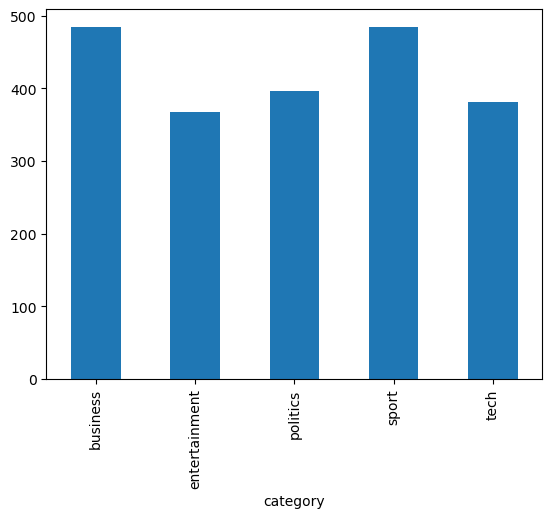

In [99]:
df.groupby('category').content.count().plot.bar(ylim=0)
plt.show()

# Preparing Data for Training

### Cleaning Text data

In [100]:
def clean_text(text,lemmatize_flag):

    stop_words = set(stopwords.words('english'))
    wn = nltk.WordNetLemmatizer() 

    text_split = text.split(" ")
    text_lc = " ".join([word.lower() for word in text_split if word not in string.punctuation and word not in stop_words]) # remove puntuation ans stopwords

    text_rc = re.sub('[0-9]+', '', text_lc)

    if lemmatize_flag == True :
        
        text_split = text_rc.split(" ")
        text = " ".join([wn.lemmatize(word) for word in text_split if word not in stop_words])  # remove stopwords and lemmetizing
    
        return text

    else:
      
        return text_rc

In [101]:
clean_data = []
for text in list(df['content']):
    clean = clean_text(str(text),lemmatize_flag = False)
    clean_data.append(clean)
df['clean_data'] = clean_data

In [102]:
df.head()

,category,content,clean_data
746,tech,Phone companies are not doing enough to warn c...,phone companies enough warn customers internet...
1434,business,"The tragedy has left at least 25,000 people de...","the tragedy left least , people dead, sri lank..."
2137,politics,Six government units would also be scrapped un...,six government units would also scrapped propo...
1762,business,Bombardier said restructuring plans drawn up b...,bombardier said restructuring plans drawn mr t...
348,sport,"J Crane (Sale Harriers Manchester), S Jones (T...","j crane (sale harriers manchester), s jones (t..."


### Data Preparation

In [103]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(df['clean_data']).toarray()
final_features.shape

(2113, 13216)

In [104]:
X = df['clean_data']
Y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

# Training

#### Logistic Regression

In [105]:
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', LogisticRegression(random_state=0))])

model = pipeline.fit(X_train, y_train)

In [106]:
with open('LogisticRegression.pickle', 'wb') as f:
    pickle.dump(model, f)

In [107]:
ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))

               precision    recall  f1-score   support

     business       0.94      0.98      0.96        50
entertainment       0.97      0.94      0.96        34
     politics       0.98      0.96      0.97        48
        sport       0.95      1.00      0.98        42
         tech       0.94      0.89      0.92        38

     accuracy                           0.96       212
    macro avg       0.96      0.95      0.96       212
 weighted avg       0.96      0.96      0.96       212



In [108]:
from sklearn.metrics import accuracy_score
print(accuracy_score(ytest,model.predict(X_test)))

0.9575471698113207


#### Random Forrest

In [109]:
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', RandomForestClassifier(max_depth = 10, random_state = 0))])

model_2 = pipeline.fit(X_train, y_train)

In [110]:
with open('RandomForest.pickle', 'wb') as f:
    pickle.dump(model_2, f)

In [111]:
ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model_2.predict(X_test)))

               precision    recall  f1-score   support

     business       0.92      0.96      0.94        50
entertainment       0.96      0.76      0.85        34
     politics       0.98      0.88      0.92        48
        sport       0.78      1.00      0.88        42
         tech       0.94      0.89      0.92        38

     accuracy                           0.91       212
    macro avg       0.92      0.90      0.90       212
 weighted avg       0.92      0.91      0.91       212



In [116]:
print(accuracy_score(ytest,model_2.predict(X_test)))

0.9056603773584906


#### Multinomial Naive Bayes

In [113]:
pipeline = Pipeline([('vect', vectorizer),
                     ('chi',  SelectKBest(chi2, k=1200)),
                     ('clf', MultinomialNB())])

model_3 = pipeline.fit(X_train, y_train)

In [114]:
with open('Multinomial_NB.pickle', 'wb') as f:
    pickle.dump(model_3, f)

In [119]:
ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model_3.predict(X_test)))

               precision    recall  f1-score   support

     business       0.96      0.98      0.97        50
entertainment       1.00      0.94      0.97        34
     politics       0.98      0.98      0.98        48
        sport       0.98      1.00      0.99        42
         tech       0.95      0.95      0.95        38

     accuracy                           0.97       212
    macro avg       0.97      0.97      0.97       212
 weighted avg       0.97      0.97      0.97       212



In [118]:
print(accuracy_score(ytest,model_3.predict(X_test)))

0.9716981132075472


# Prediction on Test data (Using the best Performing Model)

In [124]:
df_test = pd.read_csv('article_test.csv', delimiter=",", encoding='utf-8',on_bad_lines='skip',index_col = 0)

In [125]:
df_test.head()

,category,content
1135,entertainment,The independent film festival will feature two...
2009,politics,"The Archbishop of Canterbury said: ""I am pleas..."
1422,business,"As well as increasing its dividend, Nestle pla..."
1321,business,"Nearly 9,000 business leaders in 104 countries..."
240,sport,I would keep Gerrard.But when asked if Gerrard...


In [126]:
y_pred = model_3.predict(list(df_test['content']))

In [127]:
y_test_new = list(df_test['category'])

In [132]:
print(classification_report(y_test_new, y_pred))

               precision    recall  f1-score   support

     business       0.96      0.96      0.96        26
entertainment       1.00      0.84      0.91        19
     politics       0.95      0.90      0.93        21
        sport       0.90      1.00      0.95        26
         tech       0.95      1.00      0.98        20

     accuracy                           0.95       112
    macro avg       0.95      0.94      0.94       112
 weighted avg       0.95      0.95      0.95       112



In [129]:
print(accuracy_score(y_test_new,y_pred))

0.9464285714285714


In [130]:
df_test['y_pred'] = y_pred

In [141]:
df_test

,category,content,y_pred
1135,entertainment,The independent film festival will feature two...,entertainment
2009,politics,"The Archbishop of Canterbury said: ""I am pleas...",politics
1422,business,"As well as increasing its dividend, Nestle pla...",business
1321,business,"Nearly 9,000 business leaders in 104 countries...",business
240,sport,I would keep Gerrard.But when asked if Gerrard...,sport
...,...,...,...
120,sport,He was linked with the manager's job at Oldham...,sport
864,tech,The US movie industry has launched legal actio...,tech
438,sport,"But Williams said: ""I want to make it clear th...",sport
1111,entertainment,The producers behind the Lord of the Rings mus...,entertainment


#### Comparting on test data with Clustering Model

In [139]:
def cluster_prediction(text):
    
    model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    
    embeddings = list(model.encode([text]))
    
    with open('embeddings_model' , 'rb') as f:
        
        embeddings_model = pickle.load(f)

    # Dimentionality Reduction (UMAP)
    processed_embeddings = embeddings_model.transform(embeddings)
    
    with open('hdbscan_model' , 'rb') as f:
        
        cluster = pickle.load(f)

    topics = set(list(cluster.labels_))

    test_labels, strengths = hdbscan.approximate_predict(cluster, processed_embeddings)

    topic = test_labels[0]

    df = pd.read_csv('topic_info.csv')

    #print(df)
    
    df = df[df['Topic']==topic]

    description = list(df['topic_description'])[0]

    return description

In [150]:
cluster_keywords = []
for i in list(df_test['content']):
    text = clean_text(i,False)
    cluster_keywords.append(cluster_prediction(text))

In [151]:
df_test['cluster_keywords'] = cluster_keywords

In [145]:
df_test.to_csv('test_data_comparision.csv')

In [155]:
df_test['cluster_keywords'].value_counts()

Outliers                                                                  53
win england best film second cup play ireland won game                    33
labour blair party election brown howard government lord minister tory    13
search net users software tv computer microsoft service mail web           8
yukos bank economy growth economic shares china company firm oil           5
Name: cluster_keywords, dtype: int64

In [159]:
df_test

,category,content,y_pred,cluster_keywords
1135,entertainment,The independent film festival will feature two...,entertainment,win england best film second cup play ireland ...
2009,politics,"The Archbishop of Canterbury said: ""I am pleas...",politics,Outliers
1422,business,"As well as increasing its dividend, Nestle pla...",business,Outliers
1321,business,"Nearly 9,000 business leaders in 104 countries...",business,Outliers
240,sport,I would keep Gerrard.But when asked if Gerrard...,sport,Outliers
...,...,...,...,...
120,sport,He was linked with the manager's job at Oldham...,sport,win england best film second cup play ireland ...
864,tech,The US movie industry has launched legal actio...,tech,Outliers
438,sport,"But Williams said: ""I want to make it clear th...",sport,Outliers
1111,entertainment,The producers behind the Lord of the Rings mus...,entertainment,win england best film second cup play ireland ...


It Can be seen that a large portion of data has been predicted into the Outlier cluster, It is similar behaviour to the clustering seen in the "Topic_Modeling.ipynb" Notebook. 

It is to be observed that the for that are predicted into clusters other than Outliers seem to match the category.